In [2]:
!pip uninstall mmcv-full -y

Found existing installation: mmcv-full 1.5.0
Uninstalling mmcv-full-1.5.0:
  Successfully uninstalled mmcv-full-1.5.0


In [3]:
!mim install mmcv-full==1.5 -f https://download.openmmlab.com/mmcv/dist/cu117/torch2.0.0/index.html --no-deps --no-cache-dir 

Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch2.0.0/index.html, https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.8/530.8 kB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mmcv-full: filename=mmcv_full-1.5.0-cp310-cp310-linux_x86_64.whl size=31353009 sha256=ada1e954e4d6c8c31ebe7c72e0dd9a7dd147f3f2e9b0f3dd1ab8ffe42a3a63ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-zfwuqxnb/wheels/04/60/cf/301dac4d1de6b0583122bf09fe71a47ff9627d7f3837219cc9
Successfully built mmcv-full


In [1]:
# %load_ext autoreload
# %autoreload 1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

import torch
from torch import nn
from einops.layers.torch import Rearrange
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import io
import wandb
from keys import load_env

from src.utils.data_loader import FlowGeneratorExperimental
from src.utils.data_loader_strategy import DataFactoryStrategy,BatchReaderStrategyProt
from src.utils.utils import MultipartDownloader,normalize_image,load_cfg
from utilities.segmentation_utils.constants import (
    FileType,
    ImageOrdering,
)
from utilities.segmentation_utils.ImagePreprocessor import PreprocessingQueue
from src.dinov2.trainer import DINOv2Trainer
from src.dinov2.models.dinov2_model import SSLMetaArch,SSLMetaArchHSI
import src.dinov2.distributed as distributed 

from src.utils.metrics import Loss,Accuracy
import mmcv


/notebooks/src/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/notebooks/src/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/notebooks/src/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [4]:
from platform import python_version

print(python_version())
print(torch.cuda.is_available())

load_env()


3.10.13
True


In [5]:
wandb.login()

wandb: Currently logged in as: abodrogai (land-seg). Use `wandb login --relogin` to force relogin


True

In [6]:
distributed.enable(overwrite=True)

In [7]:
ARCHIVE_TRAIN_DATA_PATH = os.path.join("archive", "train")
ARCHIVE_VAL_DATA_PATH = os.path.join("archive", "val")
ARCHIVE_TEST_DATA_PATH = os.path.join("archive", "test")

MODEL_ITERATION = 6
MODEL_NAME = "unknown"
MODEL_FOLDER = "exported_models"
MODEL_LIBRARY = "models"

DATASET = os.path.join("pretrain_dataset")

TRAINING_DATA_PATH = "bchsi/pb_tr/"
VALIDATION_DATA_PATH = "bchsi/pb_val/"
TEST_DATA_PATH = os.path.join("/datasets", DATASET, "e_ts")

NUM_CLASSES = 25

LABEL_MAP = {
    1: np.array([190, 210, 255]),
    2: np.array([0, 255, 197]),
    3: np.array([38, 115, 0]),
    4: np.array([163, 255, 115]),
    5: np.array([76, 230, 0]),
    6: np.array([85, 255, 0]),
    7: np.array([115, 115, 0]),
    8: np.array([168, 168, 0]),
    9: np.array([255, 255, 0]),
    10: np.array([115, 178, 255]),
    11: np.array([0, 92, 230]),
    12: np.array([0, 38, 115]),
    13: np.array([122, 142, 245]),
    14: np.array([0, 168, 132]),
    15: np.array([115, 0, 0]),
    16: np.array([255, 127, 127]),
    17: np.array([255, 190, 190]),
    18: np.array([255, 190, 232]),
    19: np.array([255, 0, 197]),
    20: np.array([230, 0, 169]),
    21: np.array([168, 0, 132]),
    22: np.array([115, 0, 76]),
    23: np.array([255, 115, 223]),
    24: np.array([161, 161, 161]),
    0: np.array([0, 0, 0])
}


mean_per_band = np.array([
    136.43702139, 136.95781982, 136.70735693, 136.91850906, 137.12465157,
    137.26050865, 137.37743316, 137.24835798, 137.04779119, 136.9453704,
    136.79646442, 136.68328908, 136.28231996, 136.02395119, 136.01146934,
    136.72767901, 137.38975674, 137.58604882, 137.61197314, 137.46675538,
    137.57319831, 137.69239868, 137.72318172, 137.76894864, 137.74861655,
    137.77535075, 137.80038781, 137.85482571, 137.88595859, 137.9490434,
    138.00128494, 138.17846624
])
std_per_band = np.array([
    33.48886853, 33.22482796, 33.4670978,  33.53758141, 33.48675988, 33.33348355,
    33.35096189, 33.63958817, 33.85081288, 34.08314358, 34.37542553, 34.60344274,
    34.80732573, 35.17761688, 35.1956623,  34.43121367, 33.76600779, 33.77061146,
    33.92844916, 34.0370747,  34.0285642,  33.87601205, 33.81035869, 33.66611756,
    33.74440912, 33.69755911, 33.69845938, 33.6707364,  33.62571536, 33.44615438,
    33.27907802, 32.90732107
])

In [8]:
cfg = load_cfg()

In [9]:
HPARAMS = {
    'mini_batch_size': 32,
    'batch_size': 256,
    'epoch': 30,
    'criterion':nn.MSELoss,
    'optimizer': torch.optim.Adam,
    'optimizer_params': {
        'lr': 0.0001,
    },

    # loader parameters
    'shuffle': True,
    'preprocess': True,

    # model paramters
    "model_parameters":{
        "patch_size": 8,
        #encoder specific params
        "embed_dim": 768,
        # "depth": 12,
        # "num_heads": 12,
        #decoder specific params
        "decoder_embed_dim":512,
        "decoder_depth": 8,
        "decoder_num_heads": 16,
        "mlp_ratio": 4,
    },
    
    "io_params": {
        "input_size": (64,64),
        "bands": 32,
        "output_size": (64,64),
        "num_classes": NUM_CLASSES,
    },
}

In [10]:
in_queue = PreprocessingQueue(
    [
        # PreFunction(random_flip_up_down),
        # PreFunction(random_flip_left_right),
        # PreFunction(random_crop_and_resize, max_crop_percent=40.0, output_size=HPARAMS['io_params']['input_size']),
        # PreFunction(normalize_image, mean=mean_per_band, std=std_per_band),
    ],
)

val_queue = PreprocessingQueue(
    [
        # PreFunction(normalize_image, mean=mean_per_band, std=std_per_band),
    ],   
)


In [11]:
X_train = BatchReaderStrategyProt(
    os.path.join(TRAINING_DATA_PATH, "image"),
    image_size=HPARAMS['io_params']['input_size'],
)

y_train = BatchReaderStrategyProt(
    os.path.join(TRAINING_DATA_PATH, "image"),
    image_size=HPARAMS['io_params']['output_size'],
)

X_val = BatchReaderStrategyProt(
    os.path.join(VALIDATION_DATA_PATH, "image"),
    image_size=HPARAMS['io_params']['input_size'],
)

batch_reader = DataFactoryStrategy(X_train)

batch_reader_val = DataFactoryStrategy(X_val)

reader_args = {
    "input_strategy": batch_reader,
    "output_strategy": batch_reader,
    "shuffle": HPARAMS["shuffle"],
    "preprocessing_enabled": HPARAMS["preprocess"],
    "channel_mask": [True for _ in range(32)],
    "num_classes": NUM_CLASSES,
    "batch_size": HPARAMS["batch_size"],
    "image_ordering": ImageOrdering.CHANNEL_FIRST,
    "type": [FileType.MULTICHANNEL, FileType.MULTICHANNEL],
    "preprocessing_queue_image": in_queue,
    "preprocessing_queue_mask": in_queue,
}

val_reader_args = {
    "input_strategy": batch_reader_val,
    "output_strategy": batch_reader_val,
    "shuffle": False,
    "preprocessing_enabled": True,
    "channel_mask": [True for _ in range(32)],
    "num_classes": NUM_CLASSES,
    "batch_size": HPARAMS["batch_size"],
    "image_ordering": ImageOrdering.CHANNEL_FIRST,
    "type": [FileType.MULTICHANNEL, FileType.MULTICHANNEL],
    "preprocessing_queue_image": val_queue,
    "preprocessing_queue_mask": val_queue,
}


reader = FlowGeneratorExperimental(**reader_args)
val_reader = FlowGeneratorExperimental(**val_reader_args)
reader.set_mini_batch_size(HPARAMS["mini_batch_size"])
val_reader.set_mini_batch_size(HPARAMS["mini_batch_size"])


Reading from path: bchsi/pb_tr/info.csv


Reading from path: bchsi/pb_tr/info.csv
Reading from path: bchsi/pb_val/info.csv


In [12]:
import torch
from torch import nn

from src.vit_model.custom_layers import get_2d_sincos_pos_embed,Block,PatchEmbed


class DINOViTAdapter(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, encoder, img_size=224, patch_size=16, in_chans=3, 
                 embed_dim=1024, decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)

        # Use the custom encoder passed as an argument
        self.encoder = encoder

        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss
        self.in_chans = in_chans

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], self.in_chans, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * self.in_chans))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, self.in_chans))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], self.in_chans, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    
    def forward_encoder(self, x, mask_ratio):
        # Embed patches and use custom encoder
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :]
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Here, we use the custom encoder
        x = self.encoder(x)

        x = self.norm(x)
        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x,_ = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]
        x = self.unpatchify(x)
        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)
        pred_patch = self.patchify(pred)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred_patch - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.0):
        latent, mask, ids_restore,attention = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return pred, mask,attention, loss


In [13]:
class Tokenizer(nn.Module):
    def __init__(self,patch_width,patch_height):
        super().__init__()
        self.patch_width = patch_width
        self.patch_height = patch_height
        self.tokenize = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
        )
        
    def forward(self,x,mask = None):
        token = self.tokenize(x)
        if not mask is None:
            token = token[:,mask]
        return token

In [14]:


class Trainer:
    def __init__(self, model, optimizer, criterion, device,tokenizer):
        self.model = model
        self.model = self.model.cuda()
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.loss_metric = Loss()
        self.ssim_accuracy_metric = Accuracy()
        self.val_loss_metric = Loss()
        self.val_ssim_accuracy_metric = Accuracy()
        self.tokenizer = tokenizer
        self.warmup = 10


    def pca_on_images_pytorch(self,images, n_components):
        """
        Perform PCA on a batch of images using PyTorch.
        
        Args:
        images (torch.Tensor): A batch of images, shape (batch, channels, height, width).
        n_components (int): Number of principal components to keep.
        
        Returns:
        torch.Tensor: Transformed images, shape (batch, n_components).
        """
        batch, channels, height, width = images.shape
    
        # Move the channel to the last dimension and flatten the images
        images = images.permute(0, 2, 3, 1).reshape(-1, channels)
    
        # Center the data (subtract mean of each feature)
        mean = torch.mean(images, dim=0, keepdim=True)
        centered_images = images - mean
    
        # Perform SVD
        U, S, V = torch.linalg.svd(centered_images, full_matrices=False)
    
        # Selecting the principal components
        components = V.t()[:n_components]
    
        # Project the data onto principal components
        transformed_images = torch.mm(centered_images, components.t())
    
        # Reshape and move the components dimension back to the second position
        transformed_images = transformed_images.view(batch, height, width, n_components)
        transformed_images = transformed_images.permute(0, 3, 1, 2)
    
        return transformed_images



    def pca_on_image(self,tensor, n_components=None):
        """
        Perform PCA on the channel dimension of an image tensor.
    
        Args:
        tensor (torch.Tensor): An image tensor of shape (C, H, W).
        n_components (int, optional): Number of principal components to return. If None, all components are returned.
    
        Returns:
        torch.Tensor: Transformed tensor with principal components on channel dimension.
        """
        # Reshaping the tensor to 2D (C, H*W)
        C, H, W = tensor.shape
        tensor_2d = tensor.view(C, -1)  # Reshaped tensor is now (C, H*W)
    
        # Centering the data (subtract mean of each feature)
        mean = torch.mean(tensor_2d, dim=1, keepdim=True)
        centered_tensor = tensor_2d - mean
    
        # Performing SVD
        U, S, V = torch.linalg.svd(centered_tensor, full_matrices=False)
    
        # Selecting the principal components
        components = V.t()[:n_components] if n_components is not None else V.t()
    
        # Projecting the data onto principal components
        transformed_tensor = torch.mm(centered_tensor, components.t())


        # Reshaping back to original image format, if needed
        if n_components is not None:
            return transformed_tensor.view(n_components, H, W)
        else:
            return transformed_tensor.view(C, H, W)



    def _train_step(self, X, y):
        X = torch.Tensor(X).to(self.device)
        y = torch.Tensor(y).to(self.device)

        self.optimizer.zero_grad()

        print(X.shape)
        print(y.shape)
        output, mask, _, loss = self.model(X)
        
        output_cpu = output.cpu()
        pred_tokens = self.tokenizer(output_cpu)
        true_tokens = self.tokenizer(y.cpu())
    
        loss.backward()
        output_cpu = output_cpu.detach()
        self.optimizer.step()

        return loss, output_cpu,y.cpu()

    def _val_step(self, X_val, y_val):
        X_val = torch.Tensor(X_val).to(self.device)
        y_val = torch.Tensor(y_val).to(self.device)


        output, mask, attention,_ = self.model(X_val)
        
        loss = self.criterion(output, y_val)
        # if epoch >= self.warmup:
        output = self.pca_on_images_pytorch(output,n_components=3)
        y_val = self.pca_on_images_pytorch(y_val,n_components=3)
        X_val = y_val
        output_cpu = output.cpu()

        return output_cpu, loss,X_val.cpu(),y_val.cpu(),attention
    
    def _update_metrics(self, loss, output_cpu, y, is_train=True):
        y = torch.Tensor(y)
        if is_train:
            self.loss_metric.update(loss.item())
            self.ssim_accuracy_metric.update(output_cpu, y)
        else:
            self.val_loss_metric.update(loss.item())
            self.val_ssim_accuracy_metric.update(output_cpu, y)

    def _log_metrics(self, is_train=True,extra_metrics=None):
        metrics = {
            "loss": self.loss_metric.compute(),
            "accuracy": self.ssim_accuracy_metric.compute(),

        } if is_train else {
            "val_loss": self.val_loss_metric.compute(),
            "val_accuracy": self.val_ssim_accuracy_metric.compute(),
            
        }
        if extra_metrics is not None:
            metrics.update(extra_metrics)
        wandb.log(metrics)
        
    def validate(self,validation_loader,epoch):
        i = 0
        self.model.eval()
        with torch.no_grad():
            tqdm_instance_val = tqdm(validation_loader, bar_format="{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]{desc}")
            for X_val, y_val in tqdm_instance_val:
                output_cpu, loss,X_val,y_val,attention = self._val_step(X_val, y_val)
          
                self._update_metrics(loss, output_cpu, y_val, is_train=False)
                
                tqdm_instance_val.set_description(f"val_loss {self.val_loss_metric.compute():.4f}\t val_acc {self.val_ssim_accuracy_metric.compute():.4f}")
                wandb_log = {}
                if i % 50 == 0:
                    # Get the first image from input and prediction
                    input_img = torch.Tensor(X_val[0])
                    predicted_img = output_cpu.detach()[0]

                    # Average the channels to get a single-channel image
                    input_img_avg = self.rescale_for_visualization(input_img)
                    predicted_img_avg = self.rescale_for_visualization(predicted_img)
        
                    attention_cpu = attention[-1]
                    attention_cpu = attention_cpu.cpu()
                    attention_cpu = attention_cpu.mean(dim=0)

                    # Concatenate input and predicted images side by side
                    concatenated = np.hstack(
                        (input_img_avg.numpy(), predicted_img_avg.detach().numpy())
                    )
                    # Your provided loop to visualize attention

                    fig, axs = plt.subplots(1, 1, figsize=(16, 8))
                    for head in attention_cpu:
                        head = head.detach().numpy()

                    head_mean = np.mean(np.array(attention_cpu),axis=0)
                    
                    axs.imshow(head_mean)   
                    axs.axis('off')
                    axs.set_title(f'Attention Map')
                    
                    
                    wandb_log["Attention Map"] = wandb.Image(fig)
                    concatenated = np.moveaxis(concatenated,0,-1)
                    wandb_log["Input and Predicted Images"] = wandb.Image(
                        concatenated
                    )

                    # plt.close(fig)  # Close the figure to free up memory

                # # Log the images and attention maps to wandb
                self._log_metrics(is_train=False,extra_metrics=wandb_log)

                i += 1
    


    def train(self, epoch, train_loader, validation_loader=None, callbacks=None):
        torch.cuda.empty_cache()
        wandb.init(
            # set the wandb project where this 
            #  will be logged
            project="vit-dino",
            # track hyperparameters and run metadata
            config=HPARAMS,
        )

        for callback in callbacks:
            callback.on_train_start()

        for epoch_idx in range(epoch):
            
            for callback in callbacks:
                callback.on_epoch_start()

            print(f"Epoch {epoch_idx + 1}/{epoch}:")

            tqdm_instance = tqdm(
                train_loader,
                bar_format="{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]{desc}",
            )
            self.model.train()
            for X, y in tqdm_instance:
             
                
                loss, output_cpu,y = self._train_step(X, y)
                self._update_metrics(loss, output_cpu, y)
                self._log_metrics()
                tqdm_instance.set_description(f"loss {self.loss_metric.compute():.4f}\t acc {self.ssim_accuracy_metric.compute():.4f}")
                for callback in callbacks:
                    callback.on_batch_end()

            if validation_loader is not None:
                self.validate(validation_loader,epoch_idx)
            logs = {
                "loss": self.loss_metric.compute(),
                "accuracy": self.ssim_accuracy_metric.compute(),
                "val_loss": self.val_loss_metric.compute(),
                "val_accuracy": self.val_ssim_accuracy_metric.compute(),
            }
            for callback in callbacks:
                callback.on_epoch_end(epoch, logs)

            train_loader.on_epoch_end()
            torch.cuda.empty_cache()

        for callback in callbacks:
            callback.on_train_end()

        wandb.finish()
    def rescale_for_visualization(self,image):
        """
        Rescales a PyTorch tensor image to the range [0, 1] for visualization.
        """
        min_val = torch.min(image)
        max_val = torch.max(image)
        return (image - min_val) / (max_val - min_val)

    def predict(self, image):
        self.model.eval()
        bogus_gpu = image.cuda()
        output,_,_,_ = self.model(bogus_gpu)
        output_cpu = output.cpu()
        # attention_cpu = attention
        return output_cpu #attention_cpu

In [15]:


class DINODownStreamTrainer:
    def __init__(self, model, optimizer, criterion, device,tokenizer):
        self.model = model
        self.model = self.model.cuda()
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.loss_metric = Loss()
        self.ssim_accuracy_metric = Accuracy()
        self.val_loss_metric = Loss()
        self.val_ssim_accuracy_metric = Accuracy()
        self.tokenizer = tokenizer
        self.warmup = 10


    def pca_on_images_pytorch(self,images, n_components):
        """
        Perform PCA on a batch of images using PyTorch.
        
        Args:
        images (torch.Tensor): A batch of images, shape (batch, channels, height, width).
        n_components (int): Number of principal components to keep.
        
        Returns:
        torch.Tensor: Transformed images, shape (batch, n_components).
        """
        batch, channels, height, width = images.shape
    
        # Move the channel to the last dimension and flatten the images
        images = images.permute(0, 2, 3, 1).reshape(-1, channels)
    
        # Center the data (subtract mean of each feature)
        mean = torch.mean(images, dim=0, keepdim=True)
        centered_images = images - mean
    
        # Perform SVD
        U, S, V = torch.linalg.svd(centered_images, full_matrices=False)
    
        # Selecting the principal components
        components = V.t()[:n_components]
    
        # Project the data onto principal components
        transformed_images = torch.mm(centered_images, components.t())
    
        # Reshape and move the components dimension back to the second position
        transformed_images = transformed_images.view(batch, height, width, n_components)
        transformed_images = transformed_images.permute(0, 3, 1, 2)
    
        return transformed_images



    def pca_on_image(self,tensor, n_components=None):
        """
        Perform PCA on the channel dimension of an image tensor.
    
        Args:
        tensor (torch.Tensor): An image tensor of shape (C, H, W).
        n_components (int, optional): Number of principal components to return. If None, all components are returned.
    
        Returns:
        torch.Tensor: Transformed tensor with principal components on channel dimension.
        """
        # Reshaping the tensor to 2D (C, H*W)
        C, H, W = tensor.shape
        tensor_2d = tensor.view(C, -1)  # Reshaped tensor is now (C, H*W)
    
        # Centering the data (subtract mean of each feature)
        mean = torch.mean(tensor_2d, dim=1, keepdim=True)
        centered_tensor = tensor_2d - mean
    
        # Performing SVD
        U, S, V = torch.linalg.svd(centered_tensor, full_matrices=False)
    
        # Selecting the principal components
        components = V.t()[:n_components] if n_components is not None else V.t()
    
        # Projecting the data onto principal components
        transformed_tensor = torch.mm(centered_tensor, components.t())


        # Reshaping back to original image format, if needed
        if n_components is not None:
            return transformed_tensor.view(n_components, H, W)
        else:
            return transformed_tensor.view(C, H, W)



    def _train_step(self, X, y):
        X = torch.Tensor(X).to(self.device)
        y = torch.Tensor(y).to(self.device)

        self.optimizer.zero_grad()


        output, mask, _, loss = self.model(X)
        
        output_cpu = output.cpu()
        pred_tokens = self.tokenizer(output_cpu)
        true_tokens = self.tokenizer(y.cpu())
    
        loss.backward()
        output_cpu = output_cpu.detach()
        self.optimizer.step()

        return loss, output_cpu,y.cpu()

    def _val_step(self, X_val, y_val):
        X_val = torch.Tensor(X_val).to(self.device)
        y_val = torch.Tensor(y_val).to(self.device)


        output, mask, attention,_ = self.model(X_val)
        
        loss = self.criterion(output, y_val)
        # if epoch >= self.warmup:
        output = self.pca_on_images_pytorch(output,n_components=3)
        y_val = self.pca_on_images_pytorch(y_val,n_components=3)
        X_val = y_val
        output_cpu = output.cpu()

        return output_cpu, loss,X_val.cpu(),y_val.cpu(),attention
    
    def _update_metrics(self, loss, output_cpu, y, is_train=True):
        y = torch.Tensor(y)
        if is_train:
            self.loss_metric.update(loss.item())
            self.ssim_accuracy_metric.update(output_cpu, y)
        else:
            self.val_loss_metric.update(loss.item())
            self.val_ssim_accuracy_metric.update(output_cpu, y)

    def _log_metrics(self, is_train=True,extra_metrics=None):
        metrics = {
            "loss": self.loss_metric.compute(),
            "accuracy": self.ssim_accuracy_metric.compute(),

        } if is_train else {
            "val_loss": self.val_loss_metric.compute(),
            "val_accuracy": self.val_ssim_accuracy_metric.compute(),
            
        }
        if extra_metrics is not None:
            metrics.update(extra_metrics)
        wandb.log(metrics)
        
    def validate(self,validation_loader,epoch):
        i = 0
        self.model.eval()
        with torch.no_grad():
            tqdm_instance_val = tqdm(validation_loader, bar_format="{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]{desc}")
            for X_val, y_val in tqdm_instance_val:
                output_cpu, loss,X_val,y_val,attention = self._val_step(X_val, y_val)
          
                self._update_metrics(loss, output_cpu, y_val, is_train=False)
                
                tqdm_instance_val.set_description(f"val_loss {self.val_loss_metric.compute():.4f}\t val_acc {self.val_ssim_accuracy_metric.compute():.4f}")
                wandb_log = {}
                if i % 50 == 0:
                    # Get the first image from input and prediction
                    input_img = torch.Tensor(X_val[0])
                    predicted_img = output_cpu.detach()[0]

                    # Average the channels to get a single-channel image
                    input_img_avg = self.rescale_for_visualization(input_img)
                    predicted_img_avg = self.rescale_for_visualization(predicted_img)
        
                    attention_cpu = attention[-1]
                    attention_cpu = attention_cpu.cpu()
                    attention_cpu = attention_cpu.mean(dim=0)

                    # Concatenate input and predicted images side by side
                    concatenated = np.hstack(
                        (input_img_avg.numpy(), predicted_img_avg.detach().numpy())
                    )
                    # Your provided loop to visualize attention

                    fig, axs = plt.subplots(1, 1, figsize=(16, 8))
                    for head in attention_cpu:
                        head = head.detach().numpy()

                    head_mean = np.mean(np.array(attention_cpu),axis=0)
                    
                    axs.imshow(head_mean)   
                    axs.axis('off')
                    axs.set_title(f'Attention Map')
                    
                    
                    wandb_log["Attention Map"] = wandb.Image(fig)
                    concatenated = np.moveaxis(concatenated,0,-1)
                    wandb_log["Input and Predicted Images"] = wandb.Image(
                        concatenated
                    )

                    # plt.close(fig)  # Close the figure to free up memory

                # # Log the images and attention maps to wandb
                self._log_metrics(is_train=False,extra_metrics=wandb_log)

                i += 1
    


    def train(self, epoch, train_loader, validation_loader=None, callbacks=None):
        torch.cuda.empty_cache()
        wandb.init(
            # set the wandb project where this run will be logged
            project="vit-dino",
            # track hyperparameters and run metadata
            config=HPARAMS,
        )

        for callback in callbacks:
            callback.on_train_start()

        for epoch_idx in range(epoch):
            
            for callback in callbacks:
                callback.on_epoch_start()

            print(f"Epoch {epoch_idx + 1}/{epoch}:")

            tqdm_instance = tqdm(
                train_loader,
                bar_format="{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{rate_fmt}{postfix}]{desc}",
            )
            self.model.train()
            for X, y in tqdm_instance:
                
                loss, output_cpu,y = self._train_step(X, y)
                self._update_metrics(loss, output_cpu, y)
                self._log_metrics()
                tqdm_instance.set_description(f"loss {self.loss_metric.compute():.4f}\t acc {self.ssim_accuracy_metric.compute():.4f}")
                for callback in callbacks:
                    callback.on_batch_end()

            if validation_loader is not None:
                self.validate(validation_loader,epoch_idx)
            logs = {
                "loss": self.loss_metric.compute(),
                "accuracy": self.ssim_accuracy_metric.compute(),
                "val_loss": self.val_loss_metric.compute(),
                "val_accuracy": self.val_ssim_accuracy_metric.compute(),
            }
            for callback in callbacks:
                callback.on_epoch_end(epoch, logs)

            train_loader.on_epoch_end()
            torch.cuda.empty_cache()

        for callback in callbacks:
            callback.on_train_end()

        wandb.finish()
    def rescale_for_visualization(self,image):
        """
        Rescales a PyTorch tensor image to the range [0, 1] for visualization.
        """
        min_val = torch.min(image)
        max_val = torch.max(image)
        return (image - min_val) / (max_val - min_val)

    def predict(self, image):
        self.model.eval()
        bogus_gpu = image.cuda()
        output,_,_,_ = self.model(bogus_gpu)
        output_cpu = output.cpu()
        # attention_cpu = attention
        return output_cpu #attention_cpu

In [16]:
def load_weigths_to_model(model,weights):
    # load the weights from the checkpoint into the model
    new_state_dict = model.state_dict()
    print(new_state_dict.keys())
    old_state_dict = torch.load(weights)
    print(old_state_dict.keys())
    for name, param in old_state_dict.items():
        if name in new_state_dict and param.size() == new_state_dict[name].size():
            print("Loading layer: ", name)
            new_state_dict[name].copy_(param)
            param.requires_grad = False
        else:
            # Handle layers that do not match or additional processing if required
            print(f"Skipping layer: {name}, as it's not present or mismatched in the new model")
            print(param.size(), new_state_dict[name].size())
            
    
    # Load the modified state dict into the new model
    model.load_state_dict(new_state_dict, strict=False)
    return model    
    

In [30]:
import mmcv

import src.dinov2.eval.dataloader
import src.dinov2.eval.optimizers 
from src.dinov2.eval.segmentation_m2f.models import segmentors
from mmcv.runner import load_checkpoint,build_runner
from mmcv.runner import TextLoggerHook
from mmseg.apis import init_segmentor, inference_segmentor
from mmseg.models import build_segmentor
from mmcv.utils.logging import get_logger
from mmseg.datasets.builder import build_dataset, build_dataloader
import urllib
from mmcv.parallel import collate
from pprint import pprint
from mmseg.core.builder import OPTIMIZER_BUILDERS
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmseg.core.optimizers import layer_decay_optimizer_constructor
from mmseg.core.builder import build_optimizer
from src.dinov2.models import decoder
from src.dinov2.eval.patchwise_loss import PatchWiseCrossEntropyLoss
from src.dinov2.models.decoder import ResNetUNetDecoder
from src.dinov2.eval.dice_loss import DiceLossCorrect

# Print all registered optimizer builder types
print((OPTIMIZER_BUILDERS))

DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
CONFIG_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f_config.py"
CHECKPOINT_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth"

def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()
    
def load_config_from_file(path: str) -> str:
    with open(path) as f:
        return f.read()

cfg_str = load_config_from_file("configs/baseline_segmentor_cluster_cfg.py")
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")


Registry(name=optimizer builder, items={'LearningRateDecayOptimizerConstructor': <class 'mmseg.core.optimizers.layer_decay_optimizer_constructor.LearningRateDecayOptimizerConstructor'>, 'LayerDecayOptimizerConstructor': <class 'mmseg.core.optimizers.layer_decay_optimizer_constructor.LayerDecayOptimizerConstructor'>, 'LearningRateDecayOptimizerConstructorVIT': <class 'src.dinov2.eval.optimizers.LearningRateDecayOptimizerConstructorVIT'>})


In [31]:
class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output
    

from src.dinov2.eval.segmentation import models
from functools import partial
# logger_name = cfg.log_config.get('name', 'mmcv')
# log_file = cfg.log_config.get('log_file', None) # replace with your log file path if needed
# log_level = cfg.log_config.get('log_level', 'INFO')

# # Initialize the logger
logger = get_logger("mmcv")

# logger.register_hook(hook)
print("hook registerd")
model = build_segmentor(cfg.model)

load_checkpoint(model, "model_checkpoints/baseline/resnet50.pth", strict=False)


hook registerd


/notebooks/src/dinov2/eval/segmentation_m2f/models/losses/cross_entropy_loss.py:223: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: model_checkpoints/baseline/resnet50.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: backbone.layer3.6.conv1.weight, backbone.layer3.6.bn1.weight, backbone.layer3.6.bn1.bias, backbone.layer3.6.bn1.running_mean, backbone.layer3.6.bn1.running_var, backbone.layer3.6.conv2.weight, backbone.layer3.6.bn2.weight, backbone.layer3.6.bn2.bias, backbone.layer3.6.bn2.running_mean, backbone.layer3.6.bn2.running_var, backbone.layer3.6.conv3.weight, backbone.layer3.6.bn3.weight, backbone.layer3.6.bn3.bias, backbone.layer3.6.bn3.running_mean, backbone.layer3.6.bn3.running_var, backbone.layer3.7.conv1.weight, backbone.layer3.7.bn1.weight, backbone.layer3.7.bn1.bias, backbone.layer3.7.bn1.running_mean, backbone.layer3.7.bn1.running_var, backbone.layer3.7.conv2.weight, backbone.layer3.7.bn2.weight, backbone.layer3.7.bn2.bias, backbone.layer3.7.bn2.running_mean, backbone.layer3.7.bn2.running_var, backbone.layer3.7.conv3.weight, b

{'meta': {'hook_msgs': {},
  'epoch': 67,
  'iter': 39999,
  'mmcv_version': '1.5.0',
  'time': 'Sun Mar 17 21:58:35 2024'},
 'state_dict': OrderedDict([('backbone.stem.0.weight',
               tensor([[[[-0.0277,  0.0033, -0.0165],
                         [-0.0115,  0.0215, -0.0411],
                         [ 0.0295, -0.0152,  0.0548]],
               
                        [[ 0.0605, -0.0420, -0.0435],
                         [ 0.0467, -0.0186, -0.0088],
                         [ 0.0044,  0.0689, -0.0024]],
               
                        [[-0.0166,  0.0607, -0.0052],
                         [ 0.0539, -0.0254,  0.0233],
                         [ 0.0581,  0.0283,  0.0187]],
               
                        ...,
               
                        [[-0.0660, -0.0061,  0.0054],
                         [-0.0431, -0.0631, -0.0471],
                         [-0.0472, -0.0632, -0.0418]],
               
                        [[-0.0011,  0.0114, -0.0602],
     

In [32]:

# total_params = sum(p.numel() for p in model.backbone.parameters())
# print(f'{total_params:,} total parameters.')

# new_state_dict = model.state_dict()
# old_state_dict = Dino2ModelHandler.teacher.state_dict()

# populated_layers = []

# manual_mapping = {
#     "backbone.level_embed":"backbone.blocks.0.ls1.gamma",
#     "backbone.blocks.0.gamma1":"backbone.blocks.0.ls1.gamma",
#     "backbone.blocks.0.gamma2":"backbone.blocks.0.ls2.gamma",
#     "backbone.blocks.1.gamma1":"backbone.blocks.1.ls1.gamma",
#     "backbone.blocks.1.gamma2":"backbone.blocks.1.ls2.gamma",
#     "backbone.blocks.2.gamma1":"backbone.blocks.2.ls1.gamma",
#     "backbone.blocks.2.gamma2":"backbone.blocks.2.ls2.gamma",
#     "backbone.blocks.3.gamma1":"backbone.blocks.3.ls1.gamma",
#     "backbone.blocks.3.gamma2":"backbone.blocks.3.ls2.gamma",
#     "backbone.blocks.4.gamma1":"backbone.blocks.4.ls1.gamma",
#     "backbone.blocks.4.gamma2":"backbone.blocks.4.ls2.gamma",
#     "backbone.blocks.5.gamma1":"backbone.blocks.5.ls1.gamma",
#     "backbone.blocks.5.gamma2":"backbone.blocks.5.ls2.gamma",
#     "backbone.blocks.6.gamma1":"backbone.blocks.6.ls1.gamma",
#     "backbone.blocks.6.gamma2":"backbone.blocks.6.ls2.gamma",
#     "backbone.blocks.7.gamma1":"backbone.blocks.7.ls1.gamma",
#     "backbone.blocks.7.gamma2":"backbone.blocks.7.ls2.gamma",
#     "backbone.blocks.8.gamma1":"backbone.blocks.8.ls1.gamma",
#     "backbone.blocks.8.gamma2":"backbone.blocks.8.ls2.gamma",
#     "backbone.blocks.9.gamma1":"backbone.blocks.9.ls1.gamma",
#     "backbone.blocks.9.gamma2":"backbone.blocks.9.ls2.gamma",
#     "backbone.blocks.10.gamma1":"backbone.blocks.10.ls1.gamma",
#     "backbone.blocks.10.gamma2":"backbone.blocks.10.ls2.gamma",
#     "backbone.blocks.11.gamma1":"backbone.blocks.11.ls1.gamma",
#     "backbone.blocks.11.gamma2":"backbone.blocks.11.ls2.gamma",
# }

# for name, param in old_state_dict.items():
#     if name in new_state_dict and param.size() == new_state_dict[name].size():
#         # Load the state dict and freeze the layer
#         new_state_dict[name].copy_(param)
#         populated_layers.append(name)
#     else:
#         # Handle layers that do not match or additional processing if required
#         print(f"Skipping layer: {name}, as it's not present or mismatched in the new model")
#         print(f"Layer present in new model: {name in new_state_dict}")
#         print(param.size(), old_state_dict[name].size())

# # Now we freeze the populated layers by setting requires_grad to False
# for name, param in new_state_dict.items():
#     if name in populated_layers:
#         param.requires_grad = False
#     elif name not in populated_layers and name in manual_mapping:
#         # Assuming manual mapping is needed for some layers
#         print(f"Loading layer: {name} from {manual_mapping[name]}")
#         new_state_dict[name].copy_(old_state_dict[manual_mapping[name]])
#         param.requires_grad = False  # Freeze this layer as well
#         populated_layers.append(name)
#     else:
#         print(f"Layer not populated and no manual mapping provided: {name}")





In [33]:
!ls /datasets/hsi-seg/images

train  validation


In [34]:
import src.dinov2.eval.segmentation.hooks
from mmcv.runner import EvalHook, DistEvalHook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Dino2ModelHandler.to(device)
# autoencoder.to(device)
model = model.to(device)
# model.decode_head = model.decode_head.to(device)
print("Device: ",device)

model = MMDataParallel(model, device_ids=[0])  # Single GPU


# Move your model to the selected device

datasets = [
    build_dataset(cfg.data.train),
]
eval_dataset = build_dataset(cfg.data.val)


data_loaders = [
    build_dataloader(
        ds,
        samples_per_gpu = 16,
        workers_per_gpu = 1,
        seed = 42,
        drop_last = True,
        
    ) for ds in datasets
]


eval_data_loader = build_dataloader(
    eval_dataset,
    samples_per_gpu = 16,
    workers_per_gpu = 1,
    seed = 42,
    drop_last = True,
)
cfg.log_config.hooks[1].init_kwargs.config = cfg
# print(cfg.optimizer.constructor)

optimizer = build_optimizer(model, cfg.optimizer)

# criterion 
# runner = build_runner(cfg.runner, default_args=dict(
#     type="IterBasedRunner",
#     model=model,
#     logger=logger,
#     optimizer = optimizer,
#     work_dir=cfg.work_dir,
#     # meta=cfg.get('meta', None)
#     )
# )
# print(cfg.lr_config)

# eval_hook = EvalHook(eval_data_loader,by_epoch = False, interval = cfg.evaluation.interval,save_best = 'mIoU', metric = cfg.evaluation.metric, pre_eval = cfg.evaluation.pre_eval)

# runner.register_training_hooks(
#     lr_config=cfg.lr_config,
#     optimizer_config=cfg.optimizer_config,
#     checkpoint_config=cfg.checkpoint_config,
#     log_config=cfg.log_config)

# runner.register_hook(eval_hook)

# with torch.autograd.detect_anomaly():
#     runner.run(
#         data_loaders=data_loaders,
#         workflow=cfg.workflow,
#     )


2024-03-17 23:36:25,426 - mmseg - INFO - Loaded 100 images
2024-03-17 23:36:25,431 - mmseg - INFO - Loaded 12 images


cuda
Device:  cuda


In [35]:
unwrapped_model = model.module
def get_img_meta(image):
    image = np.moveaxis(image,0,-1)
    num_channels = 32
    results = dict()
    
    results['img'] = image
    results['img_shape'] = image.shape
    results['ori_shape'] = image.shape
    results['pad_shape'] = image.shape
    results['scale_factor'] = 1.0
    results['flip'] = False
    results['flip_direction'] = None
    num_channels = image.shape[2]
    results['img_norm_cfg'] = dict(
        mean=np.zeros(num_channels, dtype=np.float32),
        std=np.ones(num_channels, dtype=np.float32),
        to_rgb=False)
    return [results]

def infer(model,img):
   
    img_meta = get_img_meta(img)
    # img = np.moveaxis(img,-1,0)
    img = np.expand_dims(img, axis = 0)
    img = torch.Tensor(img).cuda()
    print(img.shape)
    
    return model.inference(img,img_meta,rescale=True)

def render(pred, shift = 0):
    colors = datasets[0].PALETTE
    colormap_array = np.array(colors, dtype=np.uint8)
    segmentation_values = colormap_array[pred +shift ]
    
    return segmentation_values





# unwrapped_model = create_segmenter(unwrapped_model, s)
unwrapped_model.cuda()
unwrapped_model.eval()





%ls /datasets/hsi-seg/images/validation

O1_0015.tif  O1_0055.tif  O1_0071.tif  O1_0079.tif  O1_0101.tif  O1_0118.tif
O1_0042.tif  O1_0067.tif  O1_0078.tif  O1_0095.tif  O1_0105.tif  O2_0035.tif


In [43]:
import rasterio
from src.dinov2.eval.dataloader import HSINormalize

file_name = "O2_0035.tif"

with rasterio.open(f"/notebooks/mock_data/images/validate/{file_name}") as src:
    img = src.read()
    img = img.astype(np.float32)
    img = img /10000


with rasterio.open(f"/notebooks/mock_data/annotations/validate/{file_name}") as src:
    an = src.read()

with torch.autograd.profiler.profile(enabled=True, record_shapes=True,with_flops=True) as prof:
    unwrapped_model.backbone(torch.Tensor(img).to('cuda:0').unsqueeze(0))
print(prof.key_averages().table(sort_by="flops"))

segmentation_logits = infer(unwrapped_model, img)
print(segmentation_logits.shape)

STAGE:2024-03-17 23:39:54 49:49 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-03-17 23:39:54 49:49 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-03-17 23:39:54 49:49 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  Total GFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         2.32%       1.020ms        20.01%       8.811ms      83.123us           106       358.093  
                                       aten::lift_fresh         0.02%      10.000us         0.02%      10.000us      10.000us             1            --  
                                               aten::to         0.02%       9.000us        47.01%      20.696ms      10.348ms             2            --  
                                         aten::_to_copy         

In [44]:

segmented_classes = np.argmax(nn.functional.softmax(segmentation_logits.detach().cpu()).numpy(), axis=1)

print(segmentation_logits.detach().cpu().numpy()[0,:,0,0])

print(np.bincount(segmented_classes.flatten()))
print(segmented_classes.shape)

[9.0310828e-11 9.1380659e-10 7.2041498e-11 4.1258347e-12 3.3907911e-12
 4.2886350e-12 6.5992298e-12 7.3569475e-12 9.3442563e-12 2.9313524e-12
 1.1996243e-12 6.4320996e-12 2.1059725e-12 3.5317068e-12 9.7537924e-12
 1.0000000e+00 7.1543574e-12 1.5114312e-12 2.0957903e-12 2.0383656e-12
 1.6629611e-12 1.3370809e-12 1.8256672e-12 5.4352141e-09]
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0 262144]
(1, 512, 512)


/tmp/ipykernel_49/2233313290.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  segmented_classes = np.argmax(nn.functional.softmax(segmentation_logits.detach().cpu()).numpy(), axis=1)


(1, 512, 512)
(1, 512, 512)


/tmp/ipykernel_49/619828792.py:22: RuntimeWarning: invalid value encountered in divide
  conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:,None]


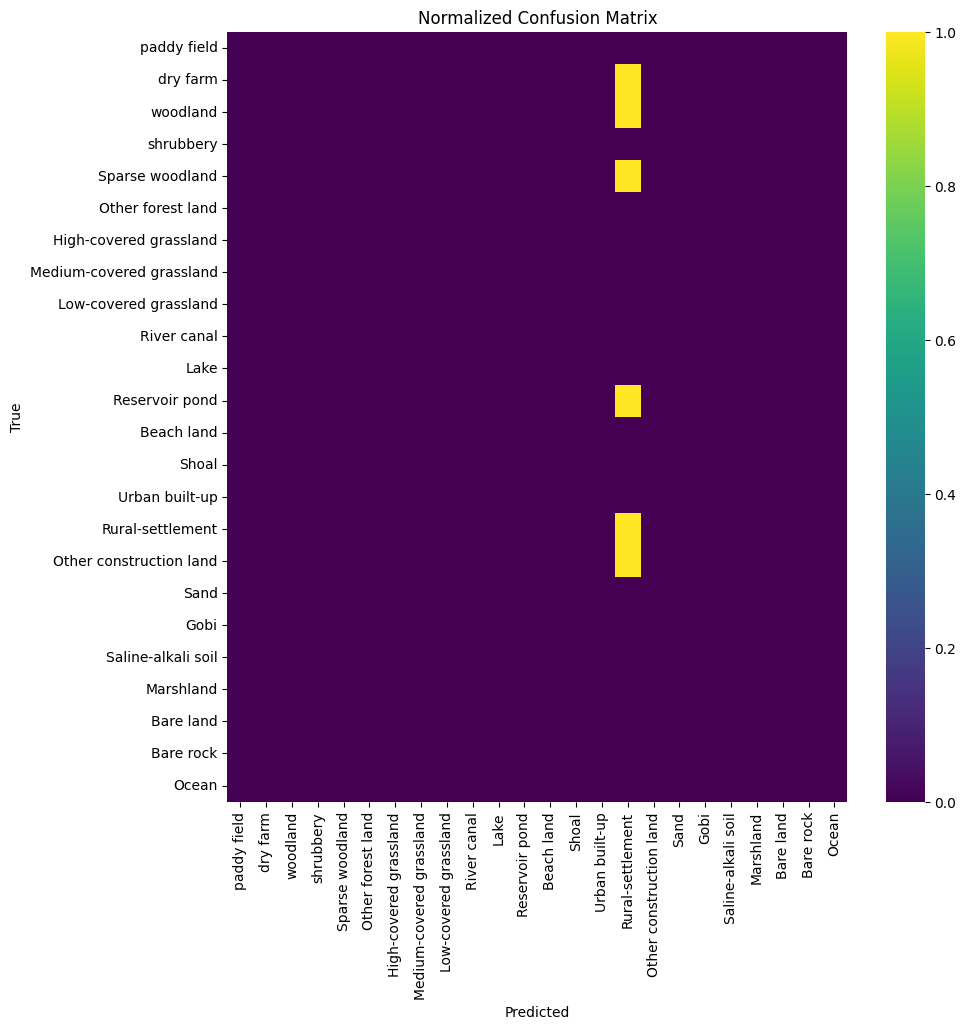

In [38]:


pred_img = render(segmented_classes[0],shift=1)
true_img = render(an[0])
print(segmented_classes.shape)
print(an.shape)



# confusion matrix


from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

adjusted_segmented_classes = segmented_classes+1


# confusion matrix ignoring the background class (segmented doesnt predict background, so we ignore only in the true label)
conf_matrix = confusion_matrix(an.flatten(),adjusted_segmented_classes.flatten(),labels = np.arange(1,25))
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:,None]
conf_matrix = np.nan_to_num(conf_matrix,nan=0.0)


plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix,annot=False,fmt=".2f",cmap="viridis",xticklabels=datasets[0].CLASSES[1:],yticklabels=datasets[0].CLASSES[1:])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()




In [39]:
# miou per class
sum_miou = 0
counter = 0
for i in range(24):
    mIoU = conf_matrix[i,i]/(conf_matrix[i,:].sum() + conf_matrix[:,i].sum() - conf_matrix[i,i])
    # check if miou is nan
    included = True
    if np.isnan(mIoU):
        mIoU = 0.0
        included = False
    else:
        sum_miou += mIoU
        counter += 1
    print(f"Class {i+1} mIoU: {mIoU}")
print(f"Average mIoU of present classes: {sum_miou/counter}")

Class 1 mIoU: 0.0
Class 2 mIoU: 0.0
Class 3 mIoU: 0.0
Class 4 mIoU: 0.0
Class 5 mIoU: 0.0
Class 6 mIoU: 0.0
Class 7 mIoU: 0.0
Class 8 mIoU: 0.0
Class 9 mIoU: 0.0
Class 10 mIoU: 0.0
Class 11 mIoU: 0.0
Class 12 mIoU: 0.0
Class 13 mIoU: 0.0
Class 14 mIoU: 0.0
Class 15 mIoU: 0.0
Class 16 mIoU: 0.16666666666666666
Class 17 mIoU: 0.0
Class 18 mIoU: 0.0
Class 19 mIoU: 0.0
Class 20 mIoU: 0.0
Class 21 mIoU: 0.0
Class 22 mIoU: 0.0
Class 23 mIoU: 0.0
Class 24 mIoU: 0.0
Average mIoU of present classes: 0.027777777777777776


/tmp/ipykernel_49/3154918085.py:5: RuntimeWarning: invalid value encountered in double_scalars
  mIoU = conf_matrix[i,i]/(conf_matrix[i,:].sum() + conf_matrix[:,i].sum() - conf_matrix[i,i])


In [40]:
from sklearn.metrics import precision_score,recall_score,f1_score

precision = precision_score(an.flatten(),adjusted_segmented_classes.flatten(),labels = np.arange(1,25),average="weighted")
recall = recall_score(an.flatten(),adjusted_segmented_classes.flatten(),labels = np.arange(1,25),average="weighted")
f1 = f1_score(an.flatten(),adjusted_segmented_classes.flatten(),labels = np.arange(1,25),average="weighted")

print(f"Precision: \t{precision}\nRecall: \t{recall}\nF1: \t\t{f1}")

Precision: 	0.0008977032862932263
Recall: 	0.033753231537873137
F1: 		0.0017488928958668494


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


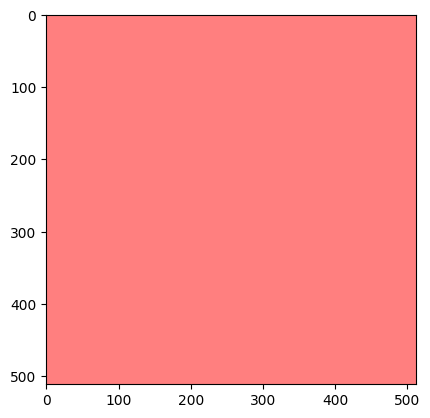

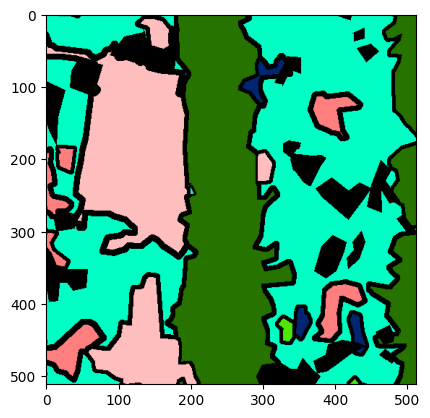

In [41]:
plt.imshow(pred_img,vmin=0, vmax=32)
plt.show()
plt.imshow(true_img,vmin=0, vmax=32)
plt.show()

# iou_map = (segmented_classes == an[:,::8,::8]).astype(np.uint8)
# plt.imshow(iou_map)
# plt.show()


In [58]:
print(cfg)

Config (path: /tmp/tmpt7yo3627.py): {'dataset_type': 'ADE20KDataset', 'data_root': '/checkpoint/dino/datasets/ADE20kChallengeData2016', 'img_norm_cfg': {'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}, 'crop_size': (64, 64), 'train_pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'LoadAnnotations', 'reduce_zero_label': True}, {'type': 'Resize', 'img_scale': (99999999, 640), 'ratio_range': (1.0, 3.0)}, {'type': 'RandomCrop', 'crop_size': (640, 640), 'cat_max_ratio': 0.75}, {'type': 'RandomFlip', 'prob': 0.5}, {'type': 'PhotoMetricDistortion'}, {'type': 'Normalize', 'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}, {'type': 'Pad', 'size': (640, 640), 'pad_val': 0, 'seg_pad_val': 255}, {'type': 'DefaultFormatBundle'}, {'type': 'Collect', 'keys': ['img', 'gt_semantic_seg']}], 'test_pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'MultiScaleFlipAug', 'img_scale': (99999999, 640), 'img_ratios': [1.0, 1.32, 1.73, 2.28

In [45]:
load_checkpoint(model, CHECKPOINT_URL, map_location='cpu')

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_ade20k_m2f.pth
 13%|█▎        | 1.39G/10.8G [00:25<02:50, 59.1MB/s] 


KeyboardInterrupt: 

In [26]:
encoder = model.backbone
print("Freezing the encoder...")
for param in encoder.parameters():
    param.requires_grad = False
adapter = DINOViTAdapter(
    encoder, 
    img_size=HPARAMS['io_params']['input_size'],
    in_chans=HPARAMS['io_params']['bands'],
    **HPARAMS["model_parameters"],
    norm_pix_loss=True
)

Freezing the encoder...


In [19]:
# AE = load_weigths_to_model(AE)


In [20]:
optim = torch.optim.AdamW(Dino2ModelHandler.get_params_groups(), betas=(cfg.optim.adamw_beta1, cfg.optim.adamw_beta2))
dino_trainer = DINOv2Trainer(
    cfg=cfg,
    model=Dino2ModelHandler,
    optimizer=optim,
    criterion=None,
    train_loader=reader,
    device=torch.device("cuda:0"),
    validation_loader=val_reader,
)

wrapped backbone with FSDP: <class 'torch.distributed.fsdp.fully_sharded_data_parallel.FullyShardedDataParallel'>
wrapped dino_head with FSDP: <class 'torch.distributed.fsdp.fully_sharded_data_parallel.FullyShardedDataParallel'>
type(self.student):  <class 'torch.nn.modules.container.ModuleDict'>
FSDP -- models synchronized across GPUs
Global size: 1
LR: 3.535533905932738e-05


In [27]:

# input_adapter = InputAdapter(32,3,3,1,1)
# output_adapter = OutputAdapter(3,32,3,1,1)
# wrapped_autoencoder= ModelAdapter(AE,input_adapter,output_adapter)

optimizer = HPARAMS["optimizer"](adapter.parameters(), **HPARAMS["optimizer_params"])
criterion = HPARAMS["criterion"]()

callbacks = []

tokenizer = Tokenizer(HPARAMS['model_parameters']['patch_size'],HPARAMS['model_parameters']['patch_size'])

trainer = Trainer(adapter, optimizer, criterion,device= "cuda",tokenizer=tokenizer)
epoch = HPARAMS["epoch"]
print(len(reader))

9608


In [28]:
trainer.train(epoch, reader, validation_loader=val_reader, callbacks=callbacks)

Epoch 1/30:


  0%|          | 0/9608 [?it/s]

torch.Size([32, 32, 64, 64])
torch.Size([32, 32, 64, 64])


ValueError: not enough values to unpack (expected 4, got 3)

In [18]:
callbacks = []
dino_trainer.train(callbacks=callbacks)

 10%|▉         | 953/9608 [ 2.16it/s]loss: 14.0361: 


KeyboardInterrupt: 

In [ ]:
torch.save(AE.state_dict(), "mae_hsi_pretrain_base.pth")

In [15]:
# model_hsi_state = torch.load("mae_hsi_pretrain_base.pth")
# AE.load_state_dict(model_hsi_state)
student = Dino2ModelHandler.student

In [ ]:
def resize_image_batch(image_batch, new_width, new_height):
    batch_size, old_height, old_width, _ = image_batch.shape

    # Create a set of indices for the new image
    x_indices = (np.arange(new_height) * (old_height / new_height)).astype(int)
    y_indices = (np.arange(new_width) * (old_width / new_width)).astype(int)

    # Use numpy's advanced indexing to pull out the correct pixels from the original image
    x_indices_mesh, y_indices_mesh = np.meshgrid(x_indices, y_indices, indexing='ij')

    # Repeat the indices arrays along the batch dimension
    x_indices_mesh = np.repeat(x_indices_mesh[np.newaxis, :, :], batch_size, axis=0)
    y_indices_mesh = np.repeat(y_indices_mesh[np.newaxis, :, :], batch_size, axis=0)

    # Index into the original image to get the resized images
    resized_images = image_batch[np.arange(batch_size)[:, np.newaxis, np.newaxis],
    x_indices_mesh, y_indices_mesh]

    return resized_images

In [ ]:
from sklearn.decomposition import PCA
def pca_on_images(images, n_components):
    """
    Perform PCA on a batch of images with shape [batch, channels, height, width].

    Args:
    images (np.array): A batch of images, shape (batch, channels, height, width).
    n_components (int): Number of principal components to keep.

    Returns:
    np.array: Transformed images, shape (batch, n_components).
    """
    # Reshape the images: flatten channels, height, and width into a single dimension
    batch, channels, height, width = images.shape
    images = np.moveaxis(images,1,-1)
    images_flattened = images.reshape(-1, channels)  # Reshapes to (batch, channels * height * width)

    # Perform PCA
    pca = PCA(n_components=n_components)
    transformed_images = pca.fit_transform(images_flattened)

    transformed_images = np.reshape(transformed_images,(batch,height,width,n_components))

    transformed_images = np.moveaxis(transformed_images,-1,1)
    return transformed_images

In [ ]:
data = MultipartDownloader("paperspace-bucket", f"bhsi/pb_val/image/batch_0.npy").download()
batch = np.load(io.BytesIO(data))
batch = batch.astype(np.float32)
batch = resize_image_batch(batch, 64, 64)

# batch = np.moveaxis(batch, -1, 1)
# batch = pca_on_images(batch, 3)
# batch = np.moveaxis(batch, -1, 1)
print(batch.shape)

(128, 64, 64, 32)


In [ ]:
print(batch.shape)
n = 79
img = batch[n].copy()
print(img.shape)
img = normalize_image(img, mean_per_band, std_per_band)
img = np.moveaxis(img, -1, 0)

img = torch.Tensor(img).unsqueeze(0)

preds = trainer.predict(img)
print(preds.min())
print(preds.max())
min = preds.min()
max = preds.max()
preds = preds+abs(min)
preds = preds/(max+abs(min))

(128, 64, 64, 32)
(64, 64, 32)
tensor(-1.5736, grad_fn=<MinBackward1>)
tensor(2.7858, grad_fn=<MaxBackward1>)


tensor([[0.5583, 0.4977, 0.4674,  ..., 0.5256, 0.5020, 0.4683],
        [0.5651, 0.5198, 0.4994,  ..., 0.4742, 0.4376, 0.3936],
        [0.5894, 0.5519, 0.5348,  ..., 0.4319, 0.3891, 0.3440],
        ...,
        [0.6101, 0.5760, 0.5425,  ..., 0.3717, 0.3810, 0.4027],
        [0.5725, 0.5336, 0.4969,  ..., 0.3131, 0.3365, 0.3820],
        [0.4843, 0.4500, 0.4198,  ..., 0.2368, 0.2672, 0.3277]],
       grad_fn=<SliceBackward0>)


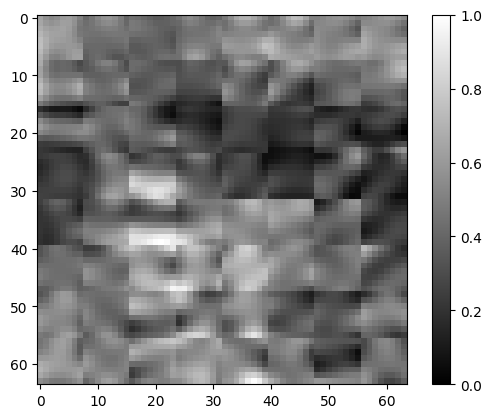

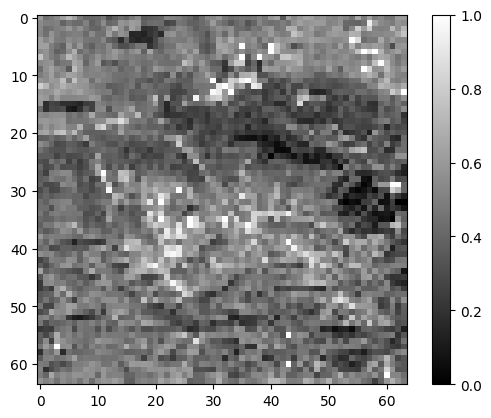

In [137]:
print(preds[0, 0, :, :])

new_pred = preds.detach().numpy()[0, :, :, :].copy()
new_pred = np.moveaxis(new_pred, 0, -1)

new_pred = new_pred[:, :, 0]

new_img = batch[n].copy()
new_img = new_img[:, :, 0]

def rescale_for_visualization(image):
    """
    Rescales an image to the range [0, 1] for visualization.
    """
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

im1 = plt.imshow(rescale_for_visualization(new_pred), vmin=0, vmax=1,cmap='gray')
plt.axis("on")
plt.colorbar(im1, orientation='vertical')  # Add colorbar
plt.show()

# Assuming batch[n] is defined and hyperspectral_to_rgb is a function you've defined
# new_img = batch[n].copy()
# new_img = hyperspectral_to_rgb(new_img)

# Plotting the second image
im2 = plt.imshow(rescale_for_visualization(new_img), vmin=0, vmax=1,cmap='gray')
plt.axis("on")
plt.colorbar(im2, orientation='vertical')  # Add colorbar
plt.show()

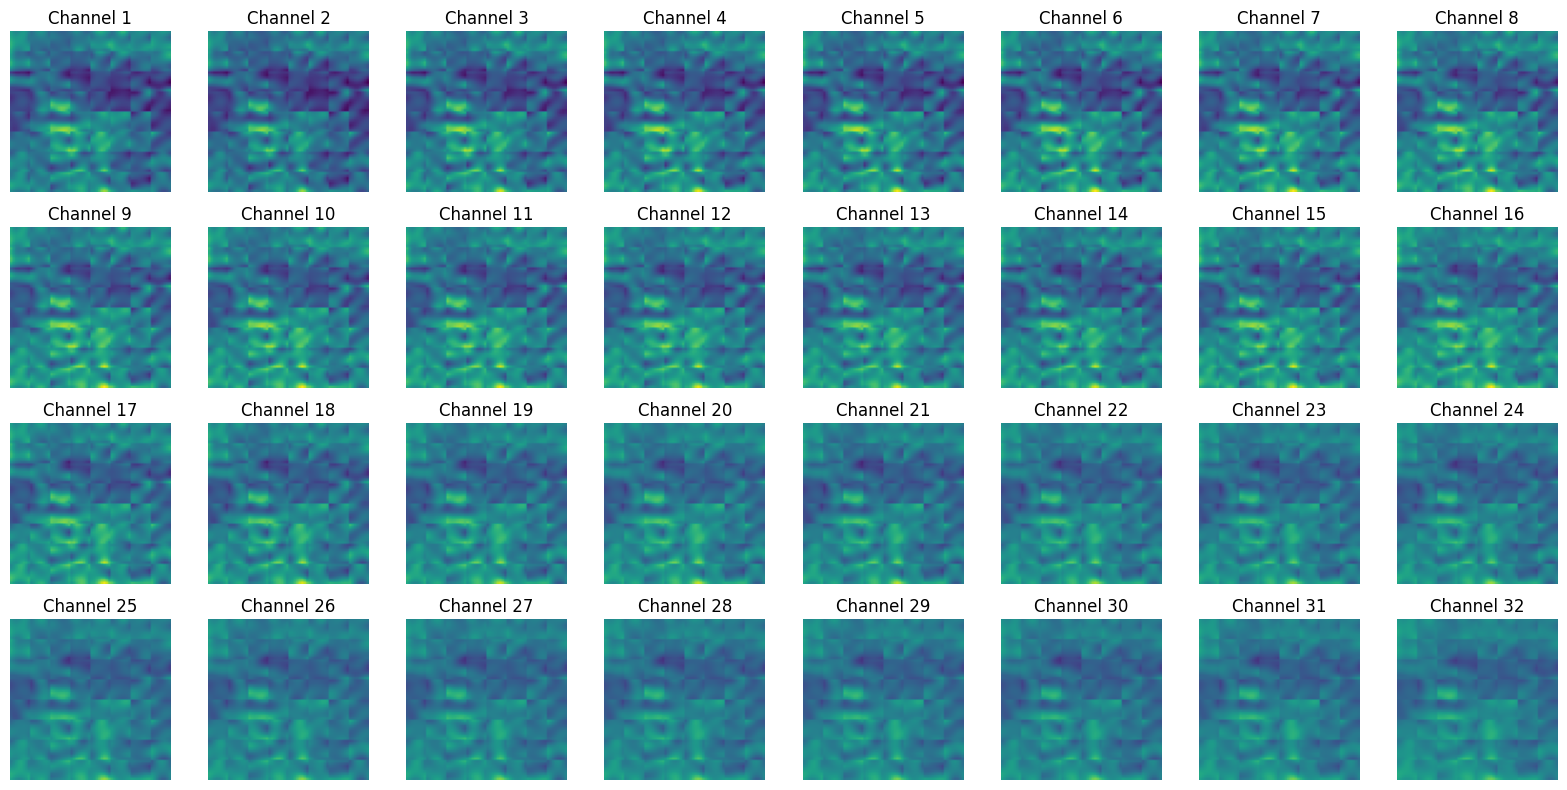

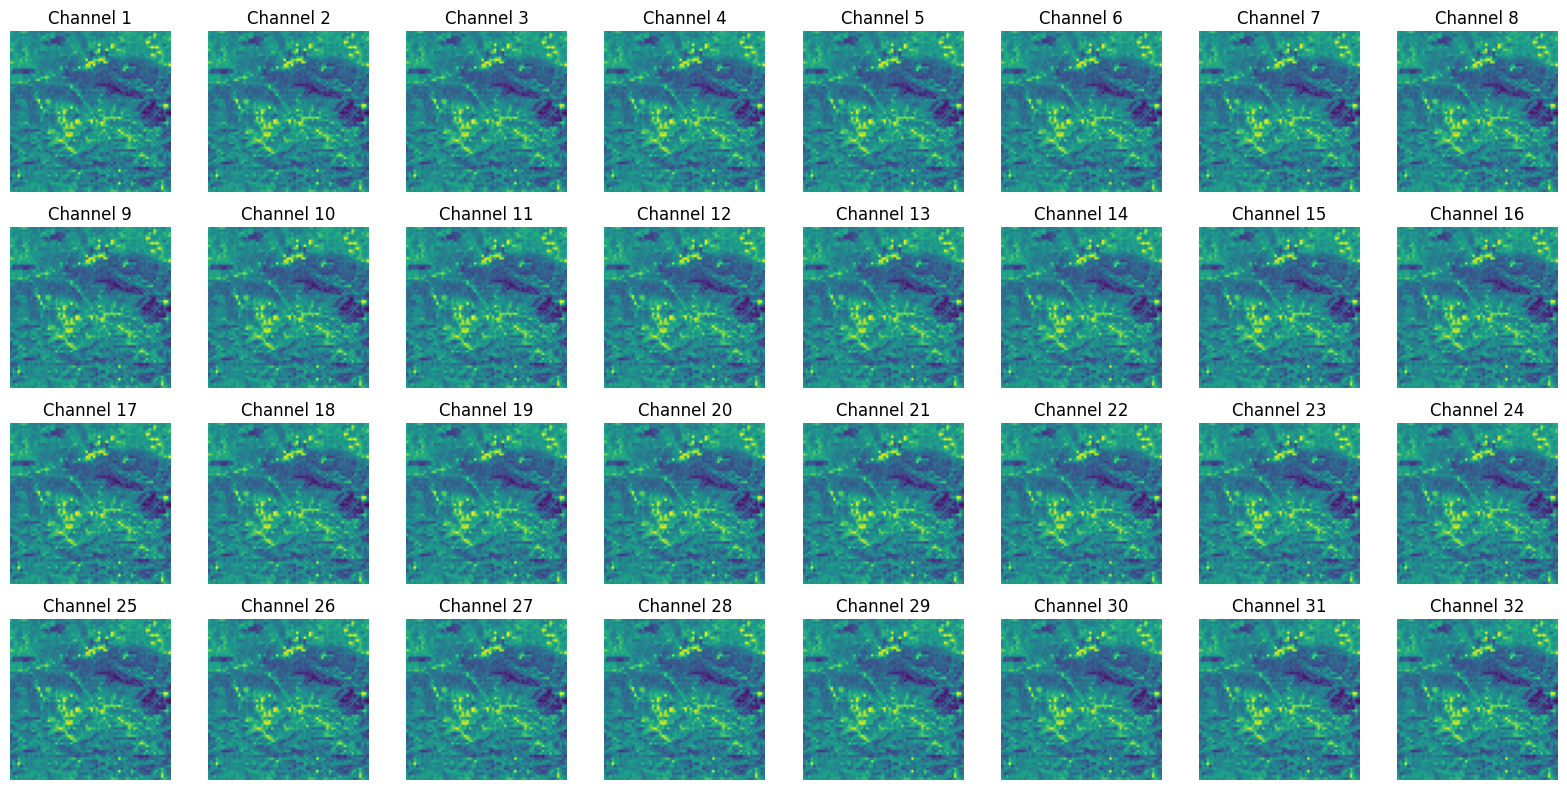

In [140]:
# Create a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Loop over channels and plot each one
for i, ax in enumerate(axs.flat):
    ax.imshow(preds[0, i, ...].detach().numpy(), vmin=0, vmax=1)  # or choose another colormap
    ax.axis('off')

    ax.set_title(f'Channel {i + 1}')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Loop over channels and plot each one
for i, ax in enumerate(axs.flat):
    ax.imshow(new_img, vmin=0, vmax=255)  # or choose another colormap
    ax.axis('off')

    ax.set_title(f'Channel {i + 1}')

plt.tight_layout()
plt.show()


torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])
torch.Size([1, 8, 65, 65])


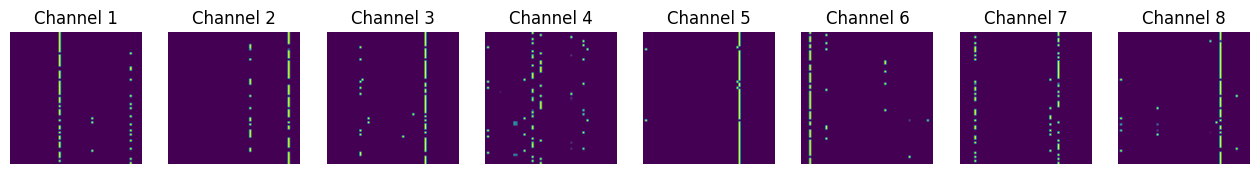

In [184]:
# Visualize attention
layer_idx = -1
head_idx = 0
fig, axs = plt.subplots(1, 8, figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    attention_layer = attention[layer_idx]
    print(attention_layer.shape)

    ax.imshow(attention[layer_idx][0, i].cpu().detach().numpy())
    ax.axis('off')
    ax.set_title(f'Channel {i + 1}')

plt.show()




(1, 65, 64)


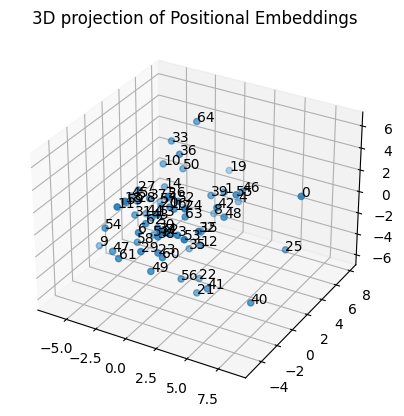

In [185]:


import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming AE.vit.pos_embedding.detach().cpu().numpy() is your data
pos_embedding = AE.vit.pos_embedding.detach().cpu().numpy()

print(pos_embedding.shape)

# Dimensionality reduction to 3D
pca = PCA(n_components=3)
pos_embedding_3d = pca.fit_transform(pos_embedding[0])

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pos_embedding_3d[:, 0], pos_embedding_3d[:, 1], pos_embedding_3d[:, 2])

for i in range(pos_embedding_3d.shape[0]):
    ax.text(pos_embedding_3d[i, 0], pos_embedding_3d[i, 1], pos_embedding_3d[i, 2], str(i))

ax.set_title('3D projection of Positional Embeddings')
plt.show()


(1, 65, 64)


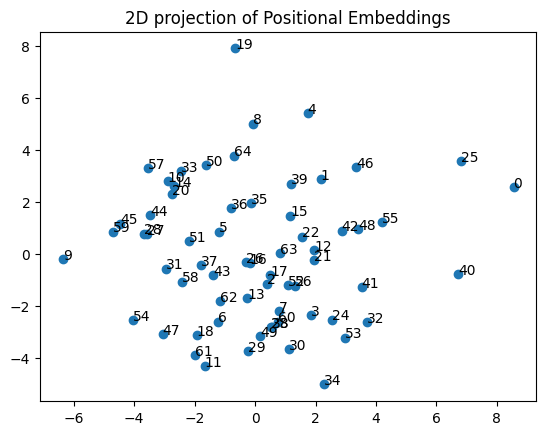

In [186]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming AE.vit.pos_embedding.detach().cpu().numpy() is your data
pos_embedding = AE.vit.pos_embedding.detach().cpu().numpy()

print(pos_embedding.shape)

# Dimensionality reduction to 2D
pca = PCA(n_components=2)
pos_embedding_2d = pca.fit_transform(pos_embedding[0])

# Create 2D scatter plot
fig, ax = plt.subplots()

ax.scatter(pos_embedding_2d[:, 0], pos_embedding_2d[:, 1])

for i in range(pos_embedding_2d.shape[0]):
    ax.text(pos_embedding_2d[i, 0], pos_embedding_2d[i, 1], str(i))

ax.set_title('2D projection of Positional Embeddings')
plt.show()


In [37]:
def compute_covariance_matrix(batch):
    batch_size = batch.shape[0]
    data = np.moveaxis(batch, -1, 1)
    data = data / 255
    mean_spectrum = np.mean(data, axis=(2, 3))

    # Subtract the mean spectrum from each pixel
    data_centered = data - mean_spectrum[:, :, np.newaxis, np.newaxis]

    # Reshape the data into a 2D array
    data_2d = data_centered.reshape((batch_size, -1, 32))

    # Compute the covariance matrix for each image in the batch
    covariance_matrices = []
    for i in range(batch_size):
        covariance_matrix = np.cov(data_2d[i].T)
        covariance_matrices.append(covariance_matrix)

    return np.array(covariance_matrices)


def combine_covariance_matrices(covariance_matrices):
    num_images = covariance_matrices.shape[0]
    combined_covariance_matrix = np.sum(covariance_matrices, axis=0) / num_images
    return combined_covariance_matrix


# Example usage

covariance_matrices = compute_covariance_matrix(batch)
combined_covariance_matrix = combine_covariance_matrices(covariance_matrices)
print(combined_covariance_matrix)


[[1.68728213e-06 9.81174978e-07 7.26383713e-07 ... 1.31827552e-07
  1.42886449e-07 1.36195546e-07]
 [9.81174978e-07 1.70156750e-06 9.70800032e-07 ... 1.28432375e-07
  1.50559297e-07 1.37294503e-07]
 [7.26383713e-07 9.70800032e-07 1.71013734e-06 ... 1.59762231e-07
  1.70551649e-07 1.45328043e-07]
 ...
 [1.31827552e-07 1.28432375e-07 1.59762231e-07 ... 1.68912129e-06
  9.64783981e-07 7.22038516e-07]
 [1.42886449e-07 1.50559297e-07 1.70551649e-07 ... 9.64783981e-07
  1.67571077e-06 9.72411236e-07]
 [1.36195546e-07 1.37294503e-07 1.45328043e-07 ... 7.22038516e-07
  9.72411236e-07 1.65851010e-06]]


In [38]:
data = batch[n].copy()
data = np.moveaxis(data, -1, 0)
data = data / 255
mean_spectrum = np.mean(data, axis=(0, 1))

# Subtract the mean spectrum from each pixel
data_centered = data - mean_spectrum

# Reshape the data into a 2D array
data_2d = data_centered.reshape((-1, 32))

# Compute the covariance matrix
covariance_matrix = np.cov(data_2d.T)

print(covariance_matrix)

[[2.40282896e-06 1.33414144e-06 1.16446371e-06 ... 4.96208126e-07
  4.14724816e-07 5.24518356e-08]
 [1.33414144e-06 2.51969975e-06 1.46119407e-06 ... 4.81310871e-07
  4.33573806e-07 1.63247839e-07]
 [1.16446371e-06 1.46119407e-06 2.63735368e-06 ... 8.19624340e-07
  7.70860976e-07 3.65732056e-07]
 ...
 [4.96208126e-07 4.81310871e-07 8.19624340e-07 ... 2.48476389e-06
  1.31404024e-06 8.78963513e-07]
 [4.14724816e-07 4.33573806e-07 7.70860976e-07 ... 1.31404024e-06
  2.34209524e-06 1.07388930e-06]
 [5.24518356e-08 1.63247839e-07 3.65732056e-07 ... 8.78963513e-07
  1.07388930e-06 2.22553151e-06]]


(32, 32)


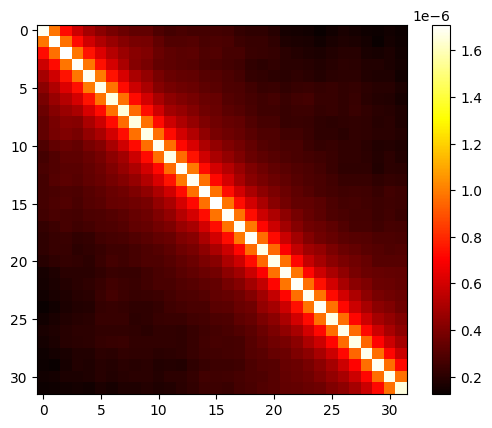

In [39]:
print(combined_covariance_matrix.shape)
plt.imshow(combined_covariance_matrix, cmap='hot')
plt.colorbar()
plt.show()

In [63]:

def linear_spectral_unmixing(hsi_data, endmembers):
    """
    Perform Linear Spectral Unmixing on Hyperspectral Image Data.
    
    Parameters:
    hsi_data (numpy array): Hyperspectral image data of shape (rows, cols, bands).
    endmembers (numpy array): Endmember signatures of shape (num_endmembers, bands).
    
    Returns:
    numpy array: Abundance maps of shape (rows, cols, num_endmembers).
    """
    # Get dimensions of the hyperspectral image data
    rows, cols, bands = hsi_data.shape

    # Ensure endmembers matrix is oriented correctly (bands, num_endmembers)
    if endmembers.shape[1] != bands:
        endmembers = endmembers.T

    num_endmembers = endmembers.shape[0]

    # Reshape the hyperspectral image data to 2D array (pixels, bands)
    hsi_data_2d = hsi_data.reshape(-1, bands)

    # Calculate the pseudo-inverse of the endmember matrix
    endmembers_pinv = np.linalg.pinv(endmembers)

    # Perform the unmixing
    abundance_maps_2d = np.dot(hsi_data_2d, endmembers_pinv)

    # Apply constraints (ensure non-negativity and sum-to-one)
    abundance_maps_2d = np.clip(abundance_maps_2d, 0, None)  # Non-negativity
    sum_abundance = np.sum(abundance_maps_2d, axis=1, keepdims=True)
    abundance_maps_2d = abundance_maps_2d / sum_abundance  # Sum-to-one

    # Reshape the abundance maps to 3D array (rows, cols, num_endmembers)
    abundance_maps = abundance_maps_2d.reshape(rows, cols, num_endmembers)

    return abundance_maps


print(data.shape)
print(endmembers.shape)
# Usage:
# Assume hsi_data is your hyperspectral image data and endmembers is your endmember signatures matrix
abundance_maps = linear_spectral_unmixing(data, endmembers)


(32, 512, 512)
(4, 512)


/tmp/ipykernel_1487/1479502286.py:33: RuntimeWarning: invalid value encountered in divide
  abundance_maps_2d = abundance_maps_2d / sum_abundance  # Sum-to-one


(32, 512, 4)


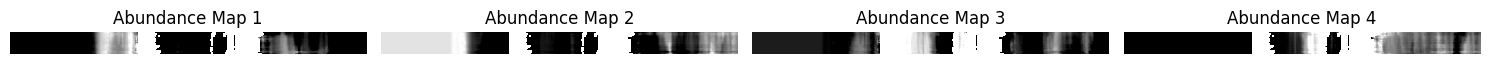

In [66]:
print(abundance_maps.shape)


def visualize_abundance_maps(abundance_maps):
    num_endmembers = abundance_maps.shape[-1]
    fig, axs = plt.subplots(1, num_endmembers, figsize=(15, 5))

    for i in range(num_endmembers):
        ax = axs[i]
        abundance_map = abundance_maps[:, :, i]
        ax.imshow(abundance_map, cmap='gray')
        ax.set_title(f'Abundance Map {i + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Usage:
# Assume abundance_maps is the output from your linear spectral unmixing function
visualize_abundance_maps(abundance_maps)


In [43]:
%pip install spectral


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 31.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [58]:

from sklearn.decomposition import FastICA

data_new = data.copy()
# Assuming hsi_data is your hyperspectral image data
# Reshape the data to 2D array
data_2d = data_new.reshape(-1, data_new.shape[-1])

# Perform ICA
ica = FastICA(n_components=4)  # Assuming 4 endmembers
S_ = ica.fit_transform(data_2d)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix, which contains the endmembers

# Each column of A_ is an endmember
endmembers = A_.T


In [54]:
print(endmembers.shape)

(4, 512)
